In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.resnet50 import preprocess_input
from pathlib import Path

data_dir = Path('C:/Delete/footwear_class/')

BATCH_SIZE = 32
IMG_SIZE = (224, 224)  
SEED = 42

full_dataset = image_dataset_from_directory(
    data_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    seed=SEED
)

class_names = full_dataset.class_names
print("Классы:", class_names)


Found 9209 files belonging to 8 classes.
Классы: ['Casual Shoes', 'Flats', 'Flip Flops', 'Formal Shoes', 'Heels', 'Sandals', 'Sports Sandals', 'Sports Shoes']


In [ ]:
import time
from tqdm import tqdm

print("Подсчет общего размера датасета...")
dataset_size = 0
progress_bar = tqdm(unit=' samples')
for batch in full_dataset:
    batch_size = batch[0].shape[0]
    dataset_size += batch_size
    progress_bar.update(batch_size)
progress_bar.close()

print(f"Общий размер датасета: {dataset_size} samples")

train_size = int(0.7 * dataset_size)
val_size = dataset_size - train_size

print(f"Разделение: Train={train_size}, Validation={val_size}")

train_dataset = full_dataset.take(train_size // BATCH_SIZE)
val_dataset = full_dataset.skip(train_size // BATCH_SIZE)

def preprocess(image, label):
    image = preprocess_input(image)  
    return image, label

print("\nПредобработка тренировочного набора...")
train_dataset = train_dataset.map(preprocess, 
                                num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

print("\nПредобработка валидационного набора...")
val_dataset = val_dataset.map(preprocess, 
                             num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

print("\nПодсчет батчей...")
train_batches = 0
val_batches = 0

with tqdm(desc="Тренировочные батчи") as pbar:
    for _ in train_dataset:
        train_batches += 1
        pbar.update(1)

with tqdm(desc="Валидационные батчи") as pbar:
    for _ in val_dataset:
        val_batches += 1
        pbar.update(1)

print(f"\nИтог: Train batches: {train_batches}, Validation batches: {val_batches}")

Подсчет общего размера датасета...


9209 samples [00:01, 7610.74 samples/s]


Общий размер датасета: 9209 samples
Разделение: Train=6446, Validation=2763

Предобработка тренировочного набора...

Предобработка валидационного набора...

Подсчет батчей...


Тренировочные батчи: 201it [00:01, 136.92it/s]
Валидационные батчи: 87it [00:01, 61.35it/s] 


Итог: Train batches: 201, Validation batches: 87


In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

NUM_CLASSES = len(class_names)

base_model = ResNet50(
    input_shape=(*IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  


model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


EPOCHS = 1
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)


base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_dataset, validation_data=val_dataset, epochs=1)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 36s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

829/829 ━━━━━━━━━━━━━━━━━━━━ 1005s 1s/step - accuracy: 0.9782 - loss: 0.0709 - val_accuracy: 0.9941 - val_loss: 0.0215
829/829 ━━━━━━━━━━━━━━━━━━━━ 1677s 2s/step - accuracy: 0.9874 - loss: 0.0447 - val_accuracy: 0.9979 - val_loss: 0.0114


In [7]:
model.save("models_new.keras")

In [8]:
model.save("models_new.h5")

In [4]:
from tensorflow.keras.models import load_model

model = load_model("models_new_niz_class.keras")
class_names = [
    "Capris",
    "Churidar",
    "Jeans",
    "Jeggings",
    "Leggings",
    "Lounge Pants",
    "Shorts",
    "Skirts",
    "Tights",
    "Track Pants",
    "Tracksuits",
    "Trousers"
]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


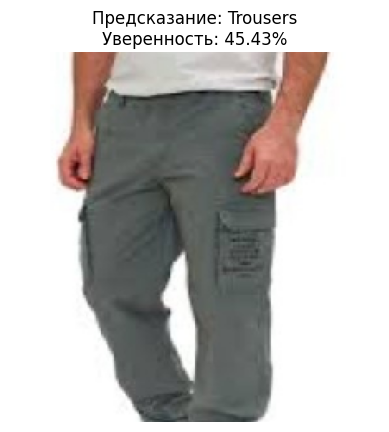


Результат: Trousers (уверенность: 45.43%)


In [7]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input

def load_and_predict(image_path, model, class_names, img_size=(224, 224)):
    """
    Загружает изображение, предобрабатывает и делает предсказание с помощью модели
    
    Параметры:
    - image_path: путь к изображению
    - model: обученная модель
    - class_names: список названий классов
    - img_size: размер изображения для модели
    
    Возвращает:
    - Предсказанный класс и его вероятность
    """

    img = image.load_img(image_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    
    img_array = preprocess_input(img_array)
    
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class = class_names[predicted_class_index]
    confidence = np.max(predictions[0]) * 100
    
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Предсказание: {predicted_class}\nУверенность: {confidence:.2f}%")
    plt.show()
    
    return predicted_class, confidence

if __name__ == "__main__":
    image_path = "example4.jpg"
    
    try:
        predicted_class, confidence = load_and_predict(image_path, model, class_names)
        print(f"\nРезультат: {predicted_class} (уверенность: {confidence:.2f}%)")
    except Exception as e:
        print(f"\nОшибка при обработке изображения: {e}")